# Preparation Work

In [1]:
#!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 468, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 468 (delta 195), reused 213 (delta 131), pack-reused 162 (from 1)
Receiving objects: 100% (468/468), 280.62 KiB | 5.61 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [1]:
cd /home/yl2672496l/Yue/code/llm/lag-llama

/home/yl2672496l/Yue/code/llm/lag-llama


In [2]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt --quiet

In [3]:
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /home/yl2672496l/Yue/code/llm/lag-llama

In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/tmp/ipykernel_924918/45153676.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
import torch
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")

Number of GPUs available: 1
GPU 0: NVIDIA A30


In [4]:
if torch.cuda.is_available():
    try:
        for i in range(torch.cuda.device_count()):
            # Set the maximum memory fraction for each GPU
            # For example, 0.5 means 50% of the GPU memory
            torch.cuda.set_per_process_memory_fraction(0.6, device=i)
        print("Memory fraction set for GPUs.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

Memory fraction set for GPUs.


# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [6]:
def get_lag_llama_predictions(dataset, prediction_length, context_length, num_samples, device, batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

# Read data

In [7]:
import numpy as np

In [8]:
import os
os.getcwd()

'/home/yl2672496l/Yue/code/llm/lag-llama'

In [9]:
traffic_data = pd.read_csv('../../GD030A_S.csv')

In [10]:
# Define the recover_timestamp function
def recover_timestamp(data):
    # Combine 'date' and 'time' to form a datetime column
    data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'].astype(str) + ':00', format='%Y-%m-%d %H:%M')

    # Set 'datetime' as index
    data = data.set_index('datetime')

    # Create a complete range of timestamps with hourly frequency
    full_time_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')

    # Reindex the data to include all timestamps, filling missing rows with NaN
    data_full = data.reindex(full_time_range)

    return data_full

In [11]:
# Apply the recover_timestamp function to recover the full time series
traffic_full = recover_timestamp(traffic_data)
traffic_full

date  time   flow
2019-10-01 00:00:00  2019-10-01   0.0   15.0
2019-10-01 01:00:00  2019-10-01   1.0    9.0
2019-10-01 02:00:00  2019-10-01   2.0    9.0
2019-10-01 03:00:00  2019-10-01   3.0    7.0
2019-10-01 04:00:00  2019-10-01   4.0    9.0
...                         ...   ...    ...
2023-09-30 19:00:00  2023-09-30  19.0  129.0
2023-09-30 20:00:00  2023-09-30  20.0  119.0
2023-09-30 21:00:00  2023-09-30  21.0  106.0
2023-09-30 22:00:00  2023-09-30  22.0   88.0
2023-09-30 23:00:00  2023-09-30  23.0   88.0

[35064 rows x 3 columns]

In [12]:
train_set = traffic_full['2022-06-03 00:00:00':'2023-03-31 23:00:00']
valid_set = traffic_full['2023-04-01 00:00:00':'2023-06-30 23:00:00']
test_set = traffic_full['2023-07-01 00:00:00':]
print('Proportion of train_set : {:.4f}'.format(len(train_set)/len(traffic_full['2022-06-03 00:00:00':])))
print('Proportion of valid_set : {:.4f}'.format(len(valid_set)/len(traffic_full['2022-06-03 00:00:00':])))
print('Proportion of test_set : {:.4f}'.format(len(test_set)/len(traffic_full['2022-06-03 00:00:00':])))

Proportion of train_set : 0.6227
Proportion of valid_set : 0.1876
Proportion of test_set : 0.1897


In [13]:
import pandas as pd
import numpy as np

def create_sequences(data, input_length, forecast_horizon):
    """
    Creates sequences for time series data, excluding any sequences containing NaN values.

    Parameters:
    - data: pandas DataFrame containing the data. Must include the 'flow' column.
    - input_length: int, number of past time steps to include in each input sequence.
    - forecast_horizon: int, number of future steps to predict.

    Returns:
    - sequences_df: pandas DataFrame containing all sequences with input lags and output leads,
                    and an 'item_id' column to separate each sequence.
    """
    sequences = []
    item_id = 0  # To assign unique ID to each sequence

    for i in range(input_length, len(data) - forecast_horizon + 1):
        # Extract the input sequence
        X_seq = data.iloc[i - input_length:i]['flow'].values
        # Extract the target sequence
        y_seq = data.iloc[i:i + forecast_horizon]['flow'].values

        # Check for NaN values in the input sequence and target sequence
        if not np.isnan(X_seq).any() and not np.isnan(y_seq).any():
            # Convert X_seq and y_seq to DataFrames
            x_df = pd.DataFrame({'target_flow': X_seq})
            y_df = pd.DataFrame({'target_flow': y_seq})

            # Concatenate X_df and y_df
            seq_df = pd.concat([x_df, y_df], ignore_index=True)

            # Add 'item_id' column
            seq_df['item_id'] = item_id
            item_id += 1  # Increment item_id

            # Append to list
            sequences.append(seq_df)
        else:
            # Optionally, log or count the skipped sequences
            pass  # Simply skip sequences with NaNs

    # Concatenate all sequences into one DataFrame
    sequences_df = pd.concat(sequences)
    sequences_df['item_id'] = sequences_df['item_id'].astype('object')
    sequences_df['target_flow'] = sequences_df['target_flow'].astype('float32')

    return sequences_df


In [14]:
# Define Input Sequence Lengths
# input_lengths = [32,64,128,256,512]
input_lengths = [24 * i for i in range(1, 22)]

In [15]:
from collections import defaultdict
data_dict = defaultdict(dict)

for length in input_lengths:
    print(f"Processing input length: {length}")

    # Create sequences with forecast_horizon=6
    train = create_sequences(train_set, length, forecast_horizon=6)
    val = create_sequences(valid_set, length, forecast_horizon=6)
    test = create_sequences(test_set, length, forecast_horizon=6)

    # Store in the dictionary
    data_dict[length]['train'] = train
    data_dict[length]['val'] = val
    data_dict[length]['test'] = test

    # Print shapes and ensure no NaNs
    print(f"  train shape: {train.index.max()+1}, {len(train.item_id.unique())}")
    print(f"  val shape: {val.index.max()+1}, {len(val.item_id.unique())}")
    print(f"  test shape: {test.index.max()+1}, {len(test.item_id.unique())}\n")

Processing input length: 24
  train shape: 30, 7145
  val shape: 30, 2007
  test shape: 30, 1719

Processing input length: 48
  train shape: 54, 7073
  val shape: 54, 1911
  test shape: 54, 1604

Processing input length: 72
  train shape: 78, 7001
  val shape: 78, 1815
  test shape: 78, 1508

Processing input length: 96
  train shape: 102, 6929
  val shape: 102, 1719
  test shape: 102, 1412

Processing input length: 120
  train shape: 126, 6857
  val shape: 126, 1623
  test shape: 126, 1316

Processing input length: 144
  train shape: 150, 6785
  val shape: 150, 1527
  test shape: 150, 1220

Processing input length: 168
  train shape: 174, 6713
  val shape: 174, 1431
  test shape: 174, 1124

Processing input length: 192
  train shape: 198, 6641
  val shape: 198, 1335
  test shape: 198, 1028

Processing input length: 216
  train shape: 222, 6569
  val shape: 222, 1239
  test shape: 222, 932

Processing input length: 240
  train shape: 246, 6497
  val shape: 246, 1143
  test shape: 246, 

# Zero-shot

In [87]:
# Create the Pandas
dataset_test = PandasDataset.from_long_dataframe(data_dict[512]['test'], target="target_flow", item_id="item_id")

context_length = 512
prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [88]:
forecasts, tss = get_lag_llama_predictions(
    dataset_test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

/tmp/ipykernel_2668490/2953498444.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
/home/yl2672496l/Yue/anaconda3

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.52 GiB. GPU 0 has a total capacity of 23.60 GiB of which 3.25 GiB is free. Including non-PyTorch memory, this process has 20.21 GiB memory in use. Of the allocated memory 10.25 GiB is allocated by PyTorch, and 9.69 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [83]:
len(forecasts), forecasts[0].samples.shape

(772, (100, 6))

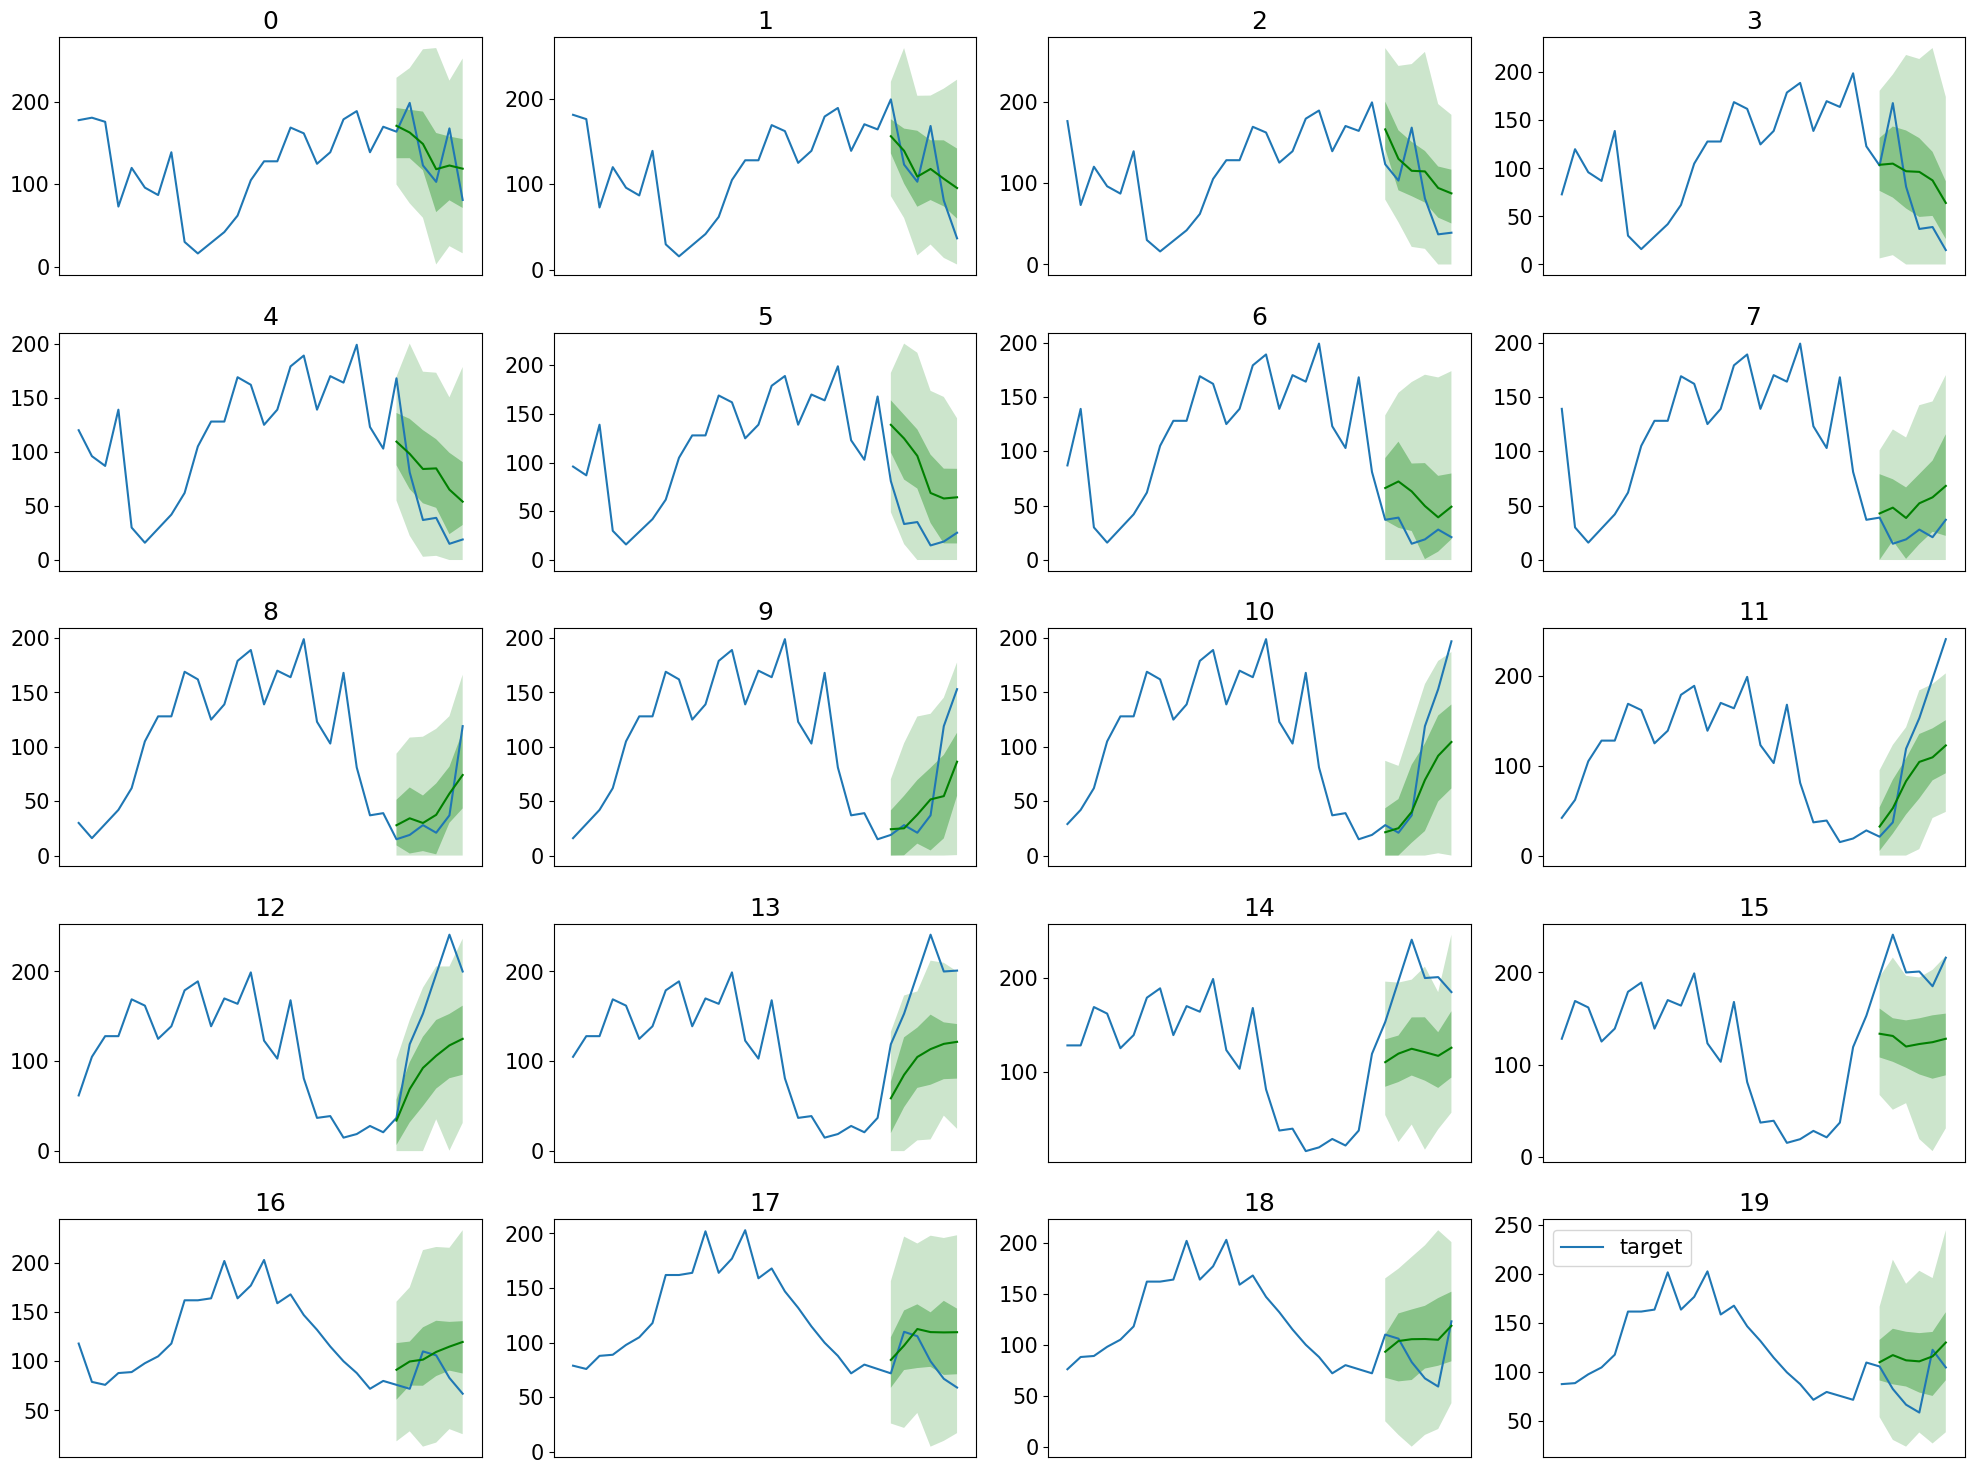

In [84]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-5 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [85]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 772it [00:00, 1590.23it/s]
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` t

| length | MAPE    | sMAPE    | MSE       | RMSE    | MAE_Coverage |
|--------|---------|----------|-----------|---------|--------------|
| 32     | 0.3796  | 0.3143   | 2493.5060 | 49.9350 | 0.3516       |
| 64     | 0.3261  | 0.2985   | 2131.2304 | 46.1652 | 0.3653       |
| 128    | 0.2758  | 0.2730   | 1770.5785 | 42.0782 | 0.3824       |
| 256    | 0.2051  | 0.1973   | 982.9911  | 31.3526 | 0.4542       |

In [86]:
agg_metrics

{'MSE': 982.9911003639867,
 'abs_error': 117112.06209564209,
 'abs_target_sum': 634229.0,
 'abs_target_mean': 136.9233592400691,
 'seasonal_error': 20.62159910596363,
 'MASE': 1.2270170348666125,
 'MAPE': 0.20510673378827454,
 'sMAPE': 0.19732061389428346,
 'MSIS': 12.735467129511218,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 70719.43195877076,
 'Coverage[0.1]': 0.0006476683937823834,
 'QuantileLoss[0.2]': 96311.52169036865,
 'Coverage[0.2]': 0.03324697754749568,
 'QuantileLoss[0.3]': 108290.56922073365,
 'Coverage[0.3]': 0.12629533678756477,
 'QuantileLoss[0.4]': 114864.66205444335,
 'Coverage[0.4]': 0.26813471502590674,
 'QuantileLoss[0.5]': 117112.06193161011,
 'Coverage[0.5]': 0.42033678756476683,
 'QuantileLoss[0.6]': 113936.14461364746,
 'Coverage[0.6]': 0.5494386873920553,
 'QuantileLoss[0.7]': 103519.10407104492,
 'Coverage[0.7]': 0.6949481865284974,
 'QuantileLoss[0.8]': 86696.88474426267,
 'Coverage[0.8]': 0.836139896373057,
 'QuantileLoss[0.9]': 62321.170505523

# Fine-tuning

In [89]:
# Create the Pandas
dataset_train = PandasDataset.from_long_dataframe(data_dict[256]['train'], target="target_flow", item_id="item_id")
dataset_test = PandasDataset.from_long_dataframe(data_dict[256]['test'], target="target_flow", item_id="item_id")
context_length = 256
prediction_length = 6  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda") 

In [90]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        distr_output="neg_bin",
        scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 100,}, # <- lightning trainer arguments
    )

/tmp/ipykernel_2668490/918048855.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


In [91]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1000)

/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/yl2672496l/Yue/anaconda

Epoch 0: |                              | 50/? [00:07<00:00,  7.09it/s, v_num=7]

Epoch 0, global step 50: 'train_loss' reached 5.14534 (best 5.14534), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |                              | 50/? [00:07<00:00,  7.10it/s, v_num=7]

Epoch 1, global step 100: 'train_loss' reached 5.03210 (best 5.03210), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |                              | 50/? [00:04<00:00, 10.55it/s, v_num=7]

Epoch 2, global step 150: 'train_loss' reached 4.52131 (best 4.52131), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |                              | 50/? [00:04<00:00, 11.60it/s, v_num=7]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |                              | 50/? [00:04<00:00, 11.57it/s, v_num=7]

Epoch 4, global step 250: 'train_loss' reached 4.50620 (best 4.50620), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |                              | 50/? [00:04<00:00, 11.65it/s, v_num=7]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: |                              | 50/? [00:04<00:00, 11.66it/s, v_num=7]

Epoch 6, global step 350: 'train_loss' reached 4.48836 (best 4.48836), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |                              | 50/? [00:04<00:00, 11.50it/s, v_num=7]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |                              | 50/? [00:04<00:00, 11.58it/s, v_num=7]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |                              | 50/? [00:04<00:00, 11.71it/s, v_num=7]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |                             | 50/? [00:04<00:00, 12.04it/s, v_num=7]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |                             | 50/? [00:04<00:00, 11.94it/s, v_num=7]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |                             | 50/? [00:04<00:00, 12.03it/s, v_num=7]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |                             | 50/? [00:04<00:00, 11.97it/s, v_num=7]

Epoch 13, global step 700: 'train_loss' reached 4.46084 (best 4.46084), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |                             | 50/? [00:04<00:00, 11.99it/s, v_num=7]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |                             | 50/? [00:04<00:00, 11.80it/s, v_num=7]

Epoch 15, global step 800: 'train_loss' reached 4.36493 (best 4.36493), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |                             | 50/? [00:04<00:00, 11.99it/s, v_num=7]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |                             | 50/? [00:04<00:00, 12.00it/s, v_num=7]

Epoch 17, global step 900: 'train_loss' reached 4.27569 (best 4.27569), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |                             | 50/? [00:04<00:00, 11.89it/s, v_num=7]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |                             | 50/? [00:04<00:00, 11.91it/s, v_num=7]

Epoch 19, global step 1000: 'train_loss' reached 4.20210 (best 4.20210), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |                             | 50/? [00:04<00:00, 12.00it/s, v_num=7]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |                             | 50/? [00:04<00:00, 11.83it/s, v_num=7]

Epoch 21, global step 1100: 'train_loss' reached 4.14242 (best 4.14242), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |                             | 50/? [00:04<00:00, 11.90it/s, v_num=7]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |                             | 50/? [00:04<00:00, 12.04it/s, v_num=7]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |                             | 50/? [00:04<00:00, 12.02it/s, v_num=7]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |                             | 50/? [00:04<00:00, 11.36it/s, v_num=7]

Epoch 25, global step 1300: 'train_loss' reached 4.14102 (best 4.14102), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |                             | 50/? [00:04<00:00, 11.90it/s, v_num=7]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |                             | 50/? [00:04<00:00, 12.01it/s, v_num=7]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |                             | 50/? [00:04<00:00, 11.98it/s, v_num=7]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |                             | 50/? [00:04<00:00, 11.69it/s, v_num=7]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |                             | 50/? [00:04<00:00, 11.93it/s, v_num=7]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |                             | 50/? [00:04<00:00, 11.94it/s, v_num=7]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |                             | 50/? [00:04<00:00, 11.97it/s, v_num=7]

Epoch 32, global step 1650: 'train_loss' reached 4.05201 (best 4.05201), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=32-step=1650.ckpt' as top 1


Epoch 33: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |                             | 50/? [00:04<00:00, 11.95it/s, v_num=7]

Epoch 34, global step 1750: 'train_loss' reached 3.97140 (best 3.97140), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |                             | 50/? [00:04<00:00, 12.04it/s, v_num=7]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 36, global step 1850: 'train_loss' reached 3.90151 (best 3.90151), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=36-step=1850.ckpt' as top 1


Epoch 37: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |                             | 50/? [00:04<00:00, 11.97it/s, v_num=7]

Epoch 38, global step 1950: 'train_loss' reached 3.85189 (best 3.85189), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |                             | 50/? [00:04<00:00, 11.98it/s, v_num=7]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |                             | 50/? [00:04<00:00, 11.84it/s, v_num=7]

Epoch 40, global step 2050: 'train_loss' reached 3.80314 (best 3.80314), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |                             | 50/? [00:04<00:00, 11.70it/s, v_num=7]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |                             | 50/? [00:04<00:00, 11.77it/s, v_num=7]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |                             | 50/? [00:04<00:00, 11.97it/s, v_num=7]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |                             | 50/? [00:04<00:00, 11.91it/s, v_num=7]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |                             | 50/? [00:04<00:00, 11.79it/s, v_num=7]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |                             | 50/? [00:04<00:00, 11.84it/s, v_num=7]

Epoch 53, global step 2700: 'train_loss' reached 3.79614 (best 3.79614), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=53-step=2700.ckpt' as top 1


Epoch 54: |                             | 50/? [00:04<00:00, 11.76it/s, v_num=7]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |                             | 50/? [00:04<00:00, 11.89it/s, v_num=7]

Epoch 55, global step 2800: 'train_loss' reached 3.73469 (best 3.73469), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=55-step=2800.ckpt' as top 1


Epoch 56: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |                             | 50/? [00:04<00:00, 11.68it/s, v_num=7]

Epoch 57, global step 2900: 'train_loss' reached 3.68993 (best 3.68993), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=57-step=2900.ckpt' as top 1


Epoch 58: |                             | 50/? [00:04<00:00, 11.77it/s, v_num=7]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |                             | 50/? [00:04<00:00, 11.94it/s, v_num=7]

Epoch 59, global step 3000: 'train_loss' reached 3.64127 (best 3.64127), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=59-step=3000.ckpt' as top 1


Epoch 60: |                             | 50/? [00:04<00:00, 11.90it/s, v_num=7]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |                             | 50/? [00:04<00:00, 11.71it/s, v_num=7]

Epoch 61, global step 3100: 'train_loss' reached 3.62346 (best 3.62346), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=61-step=3100.ckpt' as top 1


Epoch 62: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: |                             | 50/? [00:04<00:00, 11.82it/s, v_num=7]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |                             | 50/? [00:04<00:00, 11.72it/s, v_num=7]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |                             | 50/? [00:04<00:00, 11.78it/s, v_num=7]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |                             | 50/? [00:04<00:00, 11.93it/s, v_num=7]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |                             | 50/? [00:04<00:00, 11.84it/s, v_num=7]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |                             | 50/? [00:04<00:00, 11.75it/s, v_num=7]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: |                             | 50/? [00:04<00:00, 11.77it/s, v_num=7]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |                             | 50/? [00:04<00:00, 11.82it/s, v_num=7]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |                             | 50/? [00:04<00:00, 11.83it/s, v_num=7]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |                             | 50/? [00:04<00:00, 11.84it/s, v_num=7]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 78, global step 3950: 'train_loss' reached 3.59531 (best 3.59531), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=78-step=3950.ckpt' as top 1


Epoch 79: |                             | 50/? [00:04<00:00, 11.75it/s, v_num=7]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |                             | 50/? [00:04<00:00, 11.91it/s, v_num=7]

Epoch 80, global step 4050: 'train_loss' reached 3.55675 (best 3.55675), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=80-step=4050.ckpt' as top 1


Epoch 81: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |                             | 50/? [00:04<00:00, 11.80it/s, v_num=7]

Epoch 82, global step 4150: 'train_loss' reached 3.52927 (best 3.52927), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=82-step=4150.ckpt' as top 1


Epoch 83: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: |                             | 50/? [00:04<00:00, 11.86it/s, v_num=7]

Epoch 84, global step 4250: 'train_loss' reached 3.52056 (best 3.52056), saving model to '/home/yl2672496l/Yue/code/llm/lag-llama/lightning_logs/version_7/checkpoints/epoch=84-step=4250.ckpt' as top 1


Epoch 85: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |                             | 50/? [00:04<00:00, 11.72it/s, v_num=7]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |                             | 50/? [00:04<00:00, 11.79it/s, v_num=7]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |                             | 50/? [00:04<00:00, 11.77it/s, v_num=7]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: |                             | 50/? [00:04<00:00, 11.76it/s, v_num=7]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |                             | 50/? [00:04<00:00, 11.80it/s, v_num=7]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: |                             | 50/? [00:04<00:00, 11.75it/s, v_num=7]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |                             | 50/? [00:04<00:00, 11.82it/s, v_num=7]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |                             | 50/? [00:04<00:00, 11.78it/s, v_num=7]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |                             | 50/? [00:04<00:00, 11.85it/s, v_num=7]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |                             | 50/? [00:04<00:00, 11.89it/s, v_num=7]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |                             | 50/? [00:04<00:00, 11.87it/s, v_num=7]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |                             | 50/? [00:04<00:00, 11.74it/s, v_num=7]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |                             | 50/? [00:04<00:00, 11.82it/s, v_num=7]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |                             | 50/? [00:04<00:00, 11.81it/s, v_num=7]

Epoch 99, global step 5000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |                             | 50/? [00:04<00:00, 11.72it/s, v_num=7]


/home/yl2672496l/Yue/anaconda3/envs/llmtime/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [92]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset_test,
        predictor=predictor,
        num_samples=num_samples
    )

In [93]:
forecasts = list(tqdm(forecast_it, total=len(dataset_test), desc="Forecasting batches"))

Forecasting batches:   0%|                              | 0/772 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB. GPU 0 has a total capacity of 23.60 GiB of which 1003.56 MiB is free. Including non-PyTorch memory, this process has 22.48 GiB memory in use. Of the allocated memory 16.50 GiB is allocated by PyTorch, and 5.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
tss = list(tqdm(ts_it, total=len(dataset_test), desc="Ground truth"))

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 20):
    ax = plt.subplot(5, 4, idx+1)

    plt.plot(ts[-5 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

| length | MAPE    | sMAPE    | MSE       | RMSE    | MAE_Coverage |
|--------|---------|----------|-----------|---------|--------------|
| 32     | 0.3338  | 0.4437   | 2534.0593 | 50.3394 | 0.2313       |
| 64     | 0.3218  | 0.4210   | 2312.8289 | 48.0918 | 0.2267       |
| 128    | 0.2339  | 0.2584   | 1369.3422 | 37.0046 | 0.2637       |
| 256    | 0.2400  | 0.2771   | 1588.6067 | 39.8573 | 0.2492       |

In [ ]:
agg_metrics